In [1]:
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import PIL.ImageEnhance
import torch
import torch.nn.functional as F
from einops import parse_shape, rearrange, reduce
from IPython.display import JSON, Image, display
from matplotlib.ticker import PercentFormatter
from osc.data.clevr_with_masks import get_iterator
from osc.models.vit import ViTBackbone
from osc.utils import fill_diagonal
from osc.viz.utils import array_to_pil
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from timm.models import vision_transformer
from timm.models.helpers import load_custom_pretrained
from torchvision.transforms import Normalize

p = Path("scratch/")
p.mkdir(exist_ok=True)

## Model

In [2]:
Hi, Wi = 224, 224
ps = (16, 16)

model = ViTBackbone(
    img_size=(Hi, Wi),
    pos_embed_drop=0.0,
    pos_embed_every_layer=False,
    embed_dim=192,
    patch_size=ps,
    num_heads=3,
    num_layers=12,
    proj_drop=0.0,
    attn_drop=0.0,
    drop_path=0.0,
    mlp_ratio=4.0,
    output_norm=False,
)
load_custom_pretrained(
    model,
    default_cfg=vision_transformer.default_cfgs["vit_tiny_patch16_224_in21k"],
)
model.eval()

# Forward hooks to record attention maps
all_attns: Dict[torch.nn.Module, torch.Tensor] = {}
for block in model.blocks:
    block.attn.attn_drop.register_forward_hook(
        lambda m, i, o: all_attns.setdefault(m, i[0].detach())
    )

## Positional embedding

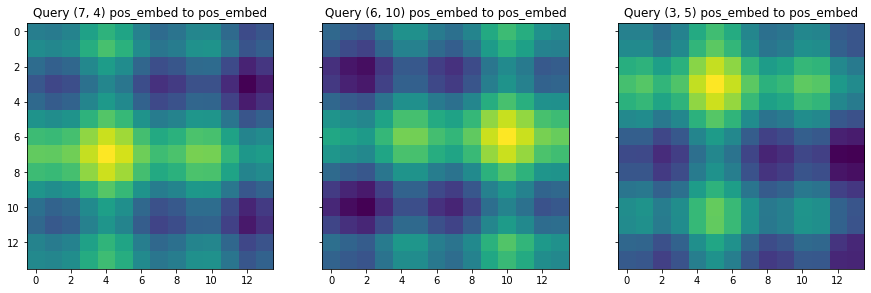

In [3]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 10), facecolor="white", sharex=True, sharey=True
)
pe = model.get_pos_embed(as_grid=True).detach()
for ax, q_hw in zip(axs, [(7, 4), (6, 10), (3, 5)]):
    q = pe[(*q_hw, slice(None))]
    ax.imshow((q * pe).sum(-1))
    ax.set_title(f"Query {q_hw} pos_embed to pos_embed")
display(fig)
plt.close(fig)

## Example images

2022-04-15 23:12:14.540240: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


viz_batch (2, 3, 3, 224, 224) torch.float32
images_np (2, 3, 224, 224, 3) uint8


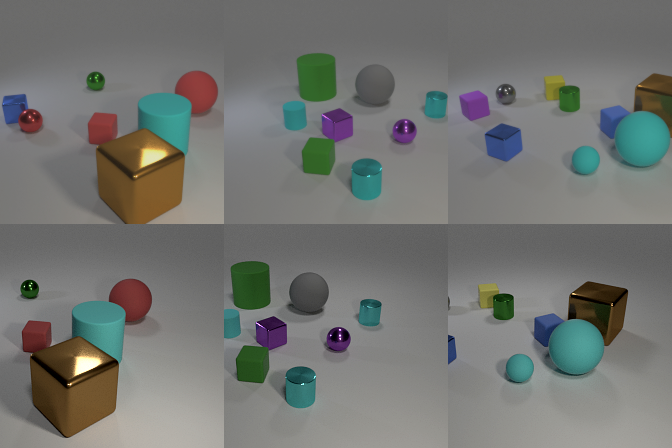

In [4]:
images_np = []
ds = (
    get_iterator("~/multi-object-datasets/", numpy=False)
    .map(lambda x: x["image"])
    .take(3)
    .as_numpy_iterator()
)
for img in ds:
    img1 = PIL.Image.fromarray(img[:Hi, 20 : 20 + Wi], "RGB")
    img1 = PIL.ImageEnhance.Color(img1).enhance(1.5)
    img1 = PIL.ImageEnhance.Sharpness(img1).enhance(0.7)
    img1 = PIL.ImageEnhance.Contrast(img1).enhance(0.8)
    img1 = np.array(img1)  # [H W C]
    images_np.append(np.array(img1))

    img2 = PIL.Image.fromarray(img[-Hi:, -10 - Wi : -10], "RGB")
    img2 = PIL.ImageEnhance.Color(img2).enhance(0.8)
    img2 = PIL.ImageEnhance.Sharpness(img2).enhance(1.5)
    img2 = PIL.ImageEnhance.Contrast(img2).enhance(1.2)
    img2 = np.array(img2)  # [H W C]
    images_np.append(np.array(img2))

# [A B H W C] torch.float32 (normalized)
viz_batch = rearrange(images_np, "(B A) H W C -> A B C H W", A=2)
viz_batch = torch.from_numpy(viz_batch.astype(np.float32) / 255.0)
viz_batch = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(viz_batch)
print("viz_batch", tuple(viz_batch.shape), viz_batch.dtype)

# [A B C H W] np.uint8
images_np = rearrange(images_np, "(B A) H W C -> A B H W C", A=2)
print("images_np", images_np.shape, images_np.dtype)

display(PIL.Image.fromarray(rearrange(images_np, "A B H W C -> (A H) (B W) C")))

## CLS token i.e. global representation

### Global pairwise similarity

Pairwise similarity of **non**-LayerNormed CLS tokens

f_global [B C]: 6 192


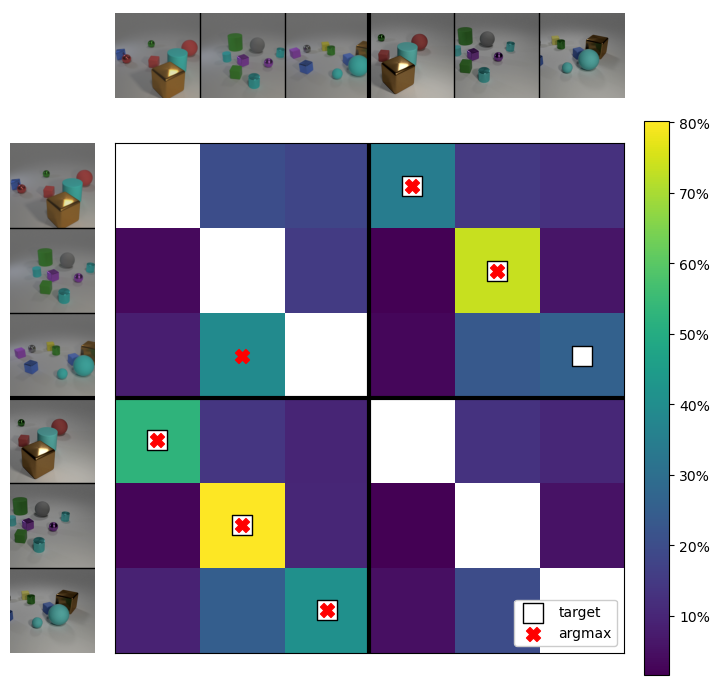

In [5]:
with torch.no_grad():
    f_global = model(rearrange(viz_batch, "A B C H W -> (A B) C H W"))[0]
    print("f_global [B C]:", *f_global.shape)
    AB, C = f_global.shape

dots = f_global @ f_global.T
attn = fill_diagonal(dots, -torch.inf).div(np.sqrt(C)).softmax(-1)

A, B, H, W, _ = images_np.shape
fig, axs = plt.subplots(
    2,
    3,
    figsize=(1+A*B+.3, 1+A*B),
    gridspec_kw={"height_ratios": [1, A*B], "width_ratios": [1, A*B, 0.3]},
    facecolor="white",
    dpi=100,
)
axs[0, 0].set_axis_off()
axs[0, 2].set_axis_off()
axs[0, 1].imshow(array_to_pil(rearrange(images_np, "A B H W C -> H (A B W) C")))
axs[0, 1].set_axis_off()
axs[1, 0].imshow(array_to_pil(rearrange(images_np, "A B H W C -> (A B H) W C")))
axs[1, 0].set_axis_off()
im = axs[1, 1].imshow(fill_diagonal(attn, torch.nan))
fig.colorbar(im, cax=axs[1, 2], format=PercentFormatter(xmax=1))
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].scatter(
    torch.arange(A*B).roll(B),
    np.arange(A*B),
    c="white",
    s=200,
    label="target",
    marker="s",
    edgecolor="black",
)
axs[1, 1].scatter(
    np.nanargmax(attn, axis=-1),
    np.arange(A*B),
    s=100,
    c="red",
    label="argmax",
    marker="X",
)
axs[1, 1].legend(loc="lower right", framealpha=1.0)
for a in range(1, A*B):
    axs[0, 1].axvline(a*W-.5, color='black', lw=1)
    axs[1, 0].axhline(a*H-.5, color='black', lw=1)
axs[0, 1].axvline(B*W-.5, color='black', lw=3)
axs[1, 0].axhline(B*H-.5, color='black', lw=3)
axs[1, 1].axhline(B-.5, color='black', lw=3)
axs[1, 1].axvline(B-.5, color='black', lw=3)
fig.tight_layout()
display(fig)
plt.close()

### CLS token rollout

The CLS token is pretty good at identifying matching pairs of augmented images.

Can we use attention rollout to see where the CLS token attending to?

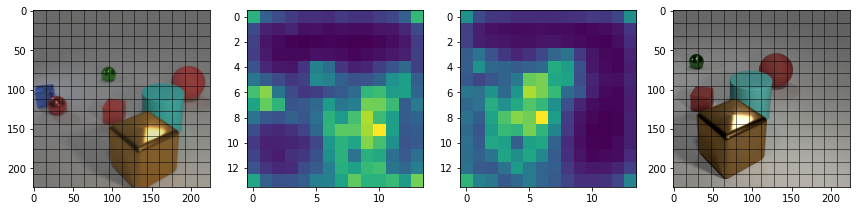

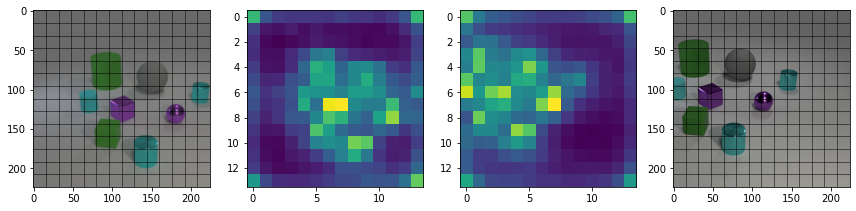

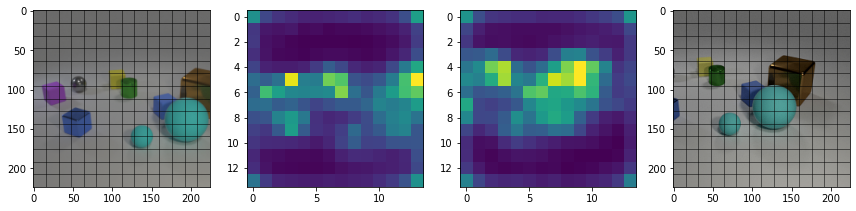

In [6]:
rollout = None
for attn in all_attns.values():
    B, _, Q, K = attn.shape
    attn = reduce(attn, "B heads Q K -> B Q K", reduction="mean")
    attn = 0.5 * (attn + torch.eye(Q, K, device=attn.device).expand(B, -1, -1))
    if rollout is None:
        rollout = torch.eye(Q, K, device=attn.device).expand(B, -1, -1)
    rollout = torch.bmm(attn, rollout)
rollout = rearrange(
    rollout[:, 0, 1:],
    "(A B) (Kh Kw) -> A B Kh Kw",
    A=2,
    Kh=model.patch_embed.grid_size[0],
)

for b in range(images_np.shape[1]):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), facecolor="white")
    for a, ax in enumerate([axs[0], axs[-1]]):
        ax.imshow(images_np[a, b])
    for a, ax in enumerate([axs[1], axs[-2]]):
        ax.imshow(rollout[a, b], interpolation="none")
    for ax in [axs[0], axs[-1]]:
        for h in np.arange(Hi, step=ps[0])[1:] - 0.5:
            ax.axhline(h, color="black", lw=0.5)
        for w in np.arange(Wi, step=ps[1])[1:] - 0.5:
            ax.axvline(w, color="black", lw=0.5)
    fig.tight_layout()
    display(fig)
    plt.close(fig)

## Patch features clustering

K-means clustering of patch features. Clustering is computed using the concatenation of all patch tokens of all augmentations of all images.

f_backbone [A B H W C]: 2 3 14 14 192


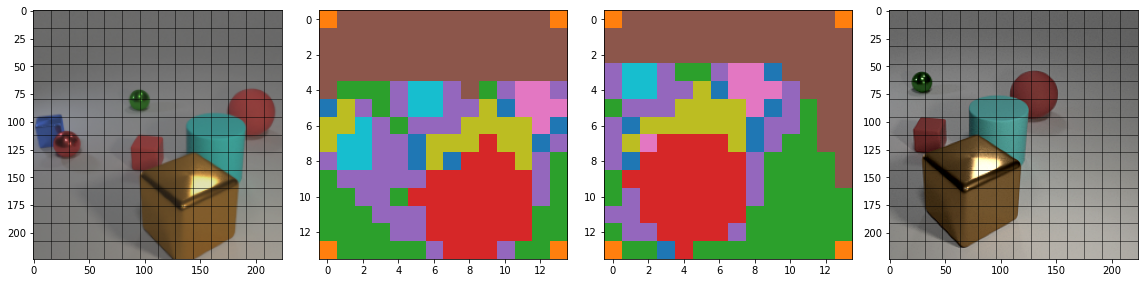

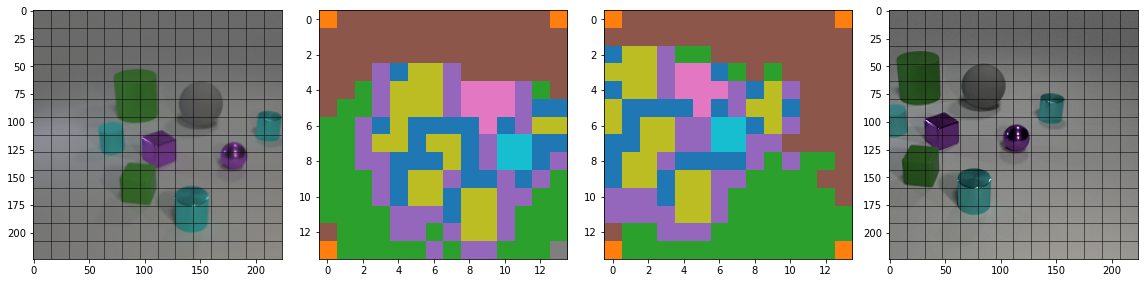

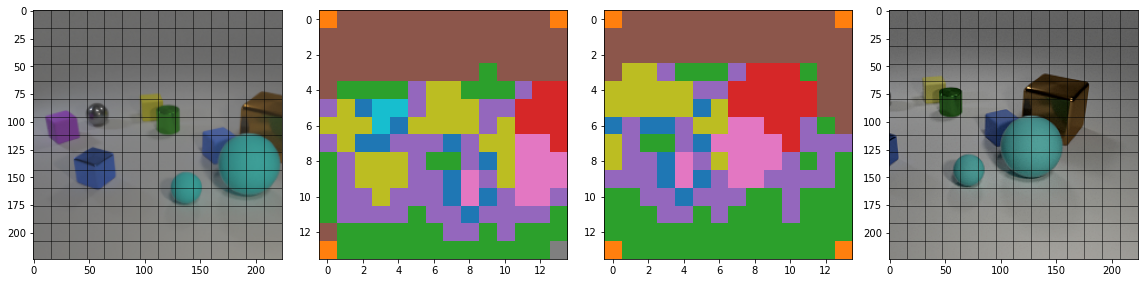

In [7]:
with torch.no_grad():
    f_backbone = model(rearrange(viz_batch, "A B C H W -> (A B) C H W"))[1]
    f_backbone = rearrange(f_backbone, "(A B) H W C -> A B H W C", A=2)
    print("f_backbone [A B H W C]:", *f_backbone.shape)
    *_, H, W, C = f_backbone.shape

kmeans = KMeans(init="k-means++", n_clusters=10, n_init=20, random_state=0)
labels = kmeans.fit_predict(rearrange(f_backbone, "A B H W C -> (A B H W) C").numpy())
labels = rearrange(labels, "(A B H W) -> A B H W", A=2, H=H, W=W)
labels = plt.get_cmap("tab10")(labels)  # [A B H W rgba]

for b in range(images_np.shape[1]):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), facecolor="white")
    for a, ax in enumerate([axs[0], axs[-1]]):
        ax.imshow(images_np[a, b])
    for a, ax in enumerate([axs[1], axs[-2]]):
        ax.imshow(labels[a, b], interpolation="none")
    for ax in [axs[0], axs[-1]]:
        for h in np.arange(Hi, step=ps[0])[1:] - 0.5:
            ax.axhline(h, color="black", lw=0.5)
        for w in np.arange(Wi, step=ps[1])[1:] - 0.5:
            ax.axvline(w, color="black", lw=0.5)
    fig.tight_layout()
    display(fig)
    plt.close(fig)

2D TSNE visualization of patch tokens. Each marker is a token. The colors are taken from the input images.

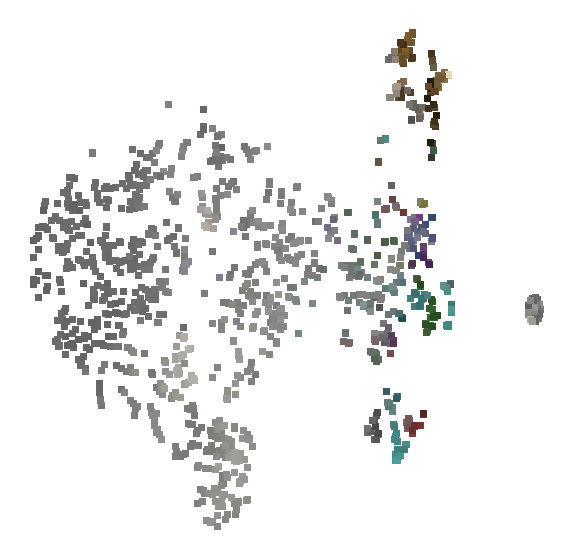

In [8]:
avg_patch_color = reduce(
    images_np / 255.0,
    "A B (H Ph) (W Pw) C -> (A B H W) C",
    Ph=ps[0],
    Pw=ps[1],
    reduction="mean",
)

tsne = TSNE(
    n_components=2,
    init="random",
    learning_rate="auto",
    metric="cosine",
    random_state=0,
    square_distances=True,
)
proj = tsne.fit_transform(rearrange(f_backbone, "A B H W C -> (A B H W) C").numpy())

fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
ax.scatter(*proj.T, color=avg_patch_color, marker="s")
ax.set_axis_off()
display(fig)
plt.close(fig)

## Figure for poster

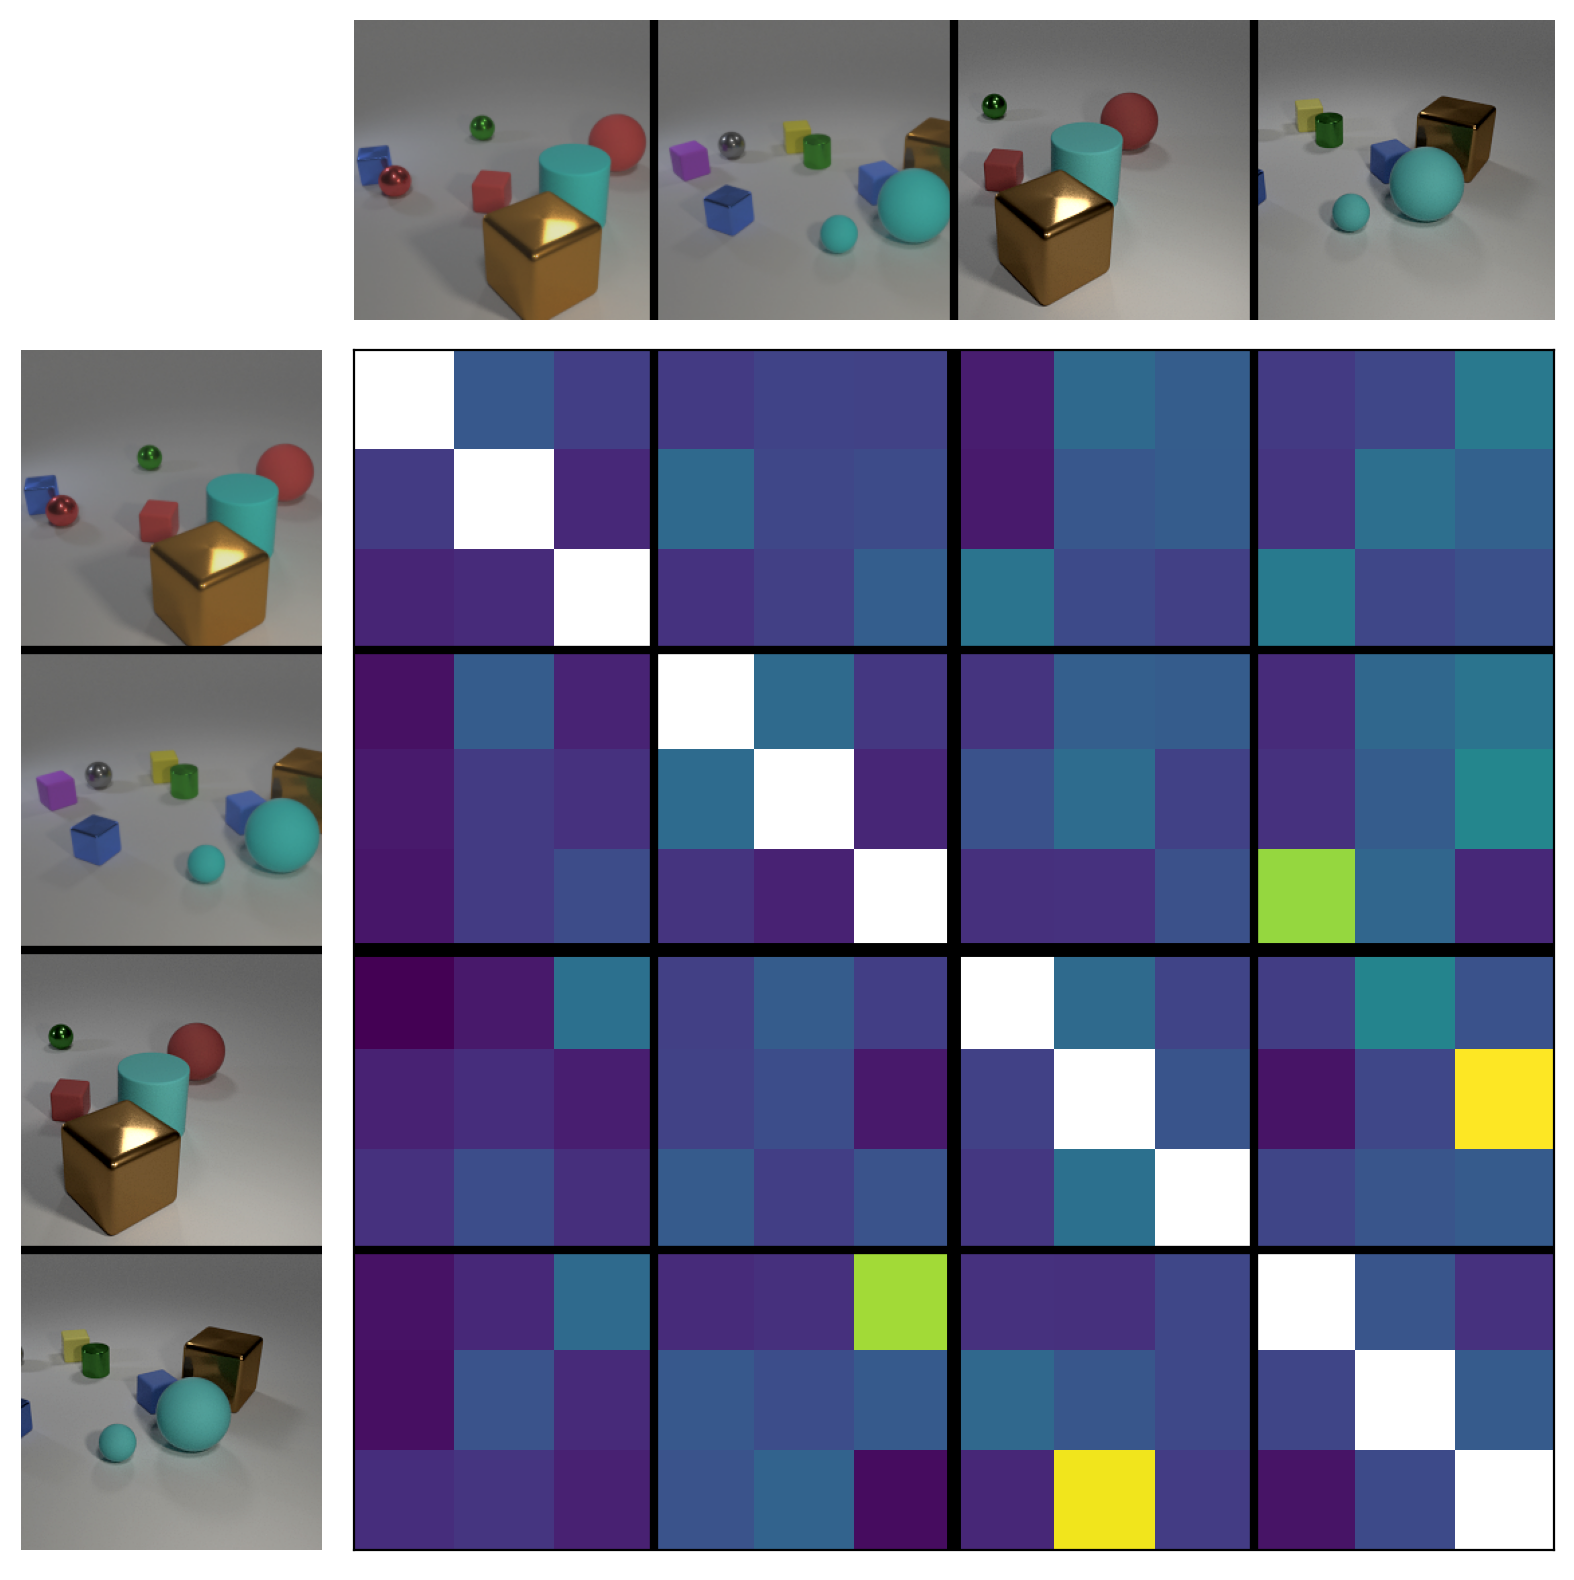

In [9]:
def gnam():    
    A = 2
    B = 2
    S = 3
    # [(A B S) C]
    tokens = torch.stack([f_backbone[abhw] for abhw in [
        # Augmentation 0
        (0, 0, 11, 9),
        (0, 0, 8, 11),
        (0, 0, 5, 13 ),
        (0, 2, 6, 1),
        (0, 2, 8, 3),
        (0, 2, 8, 12),
        # Augmentation 1
        (1, 0, 3, 1 ),
        (1, 0, 9, 4),
        (1, 0, 5, 5 ),
        (1, 2, 7, 7 ),
        (1, 2, 5, 3),
        (1, 2, 4, 10),
    ]])
    dots = (tokens @ tokens.T).div(tokens.shape[-1])
    attn = fill_diagonal(dots, -torch.inf).softmax(-1)
    
    fig, axs = plt.subplots(
        2,
        2,
        figsize=(8, 8),
        gridspec_kw={"height_ratios": [1, A*B], "width_ratios": [1, A*B]},
        facecolor="white",
        dpi=200,
    )
    
    H, W = images_np.shape[-3:-1]
    axs[0, 0].set_axis_off()
    axs[0, 1].imshow(array_to_pil(rearrange(images_np[:, [0, 2]], "A B H W C -> H (A B W) C")))
    for a in range(1, A*B):
        axs[0, 1].axvline(a*W-.5, color='black', lw=3)
        axs[1, 0].axhline(a*W-.5, color='black', lw=3)
    axs[0, 1].set_axis_off()
    axs[1, 0].imshow(array_to_pil(rearrange(images_np[:, [0, 2]], "A B H W C -> (A B H) W C")))
    axs[1, 0].set_axis_off()
    
    axs[1, 1].imshow(fill_diagonal(attn, torch.nan))
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    for s in range(S, A*B*S, S):
        axs[1, 1].axhline(s-.5, color='black', lw=3)
        axs[1, 1].axvline(s-.5, color='black', lw=3)
    axs[1, 1].axhline(B*S-.5, color='black', lw=5)
    axs[1, 1].axvline(B*S-.5, color='black', lw=5)
    fig.tight_layout()
    display(fig)
    plt.close()
    
gnam()

## Patch features similarity

In [10]:
def segments_to_image(segments, resize_HW=None):
    H, W = segments.shape
    cmap = plt.get_cmap("tab10")
    segments = np.array(segments)  # cmap does not work well on torch.Tensor
    img = cmap(segments)[:, :, :3]  # No alpha channel
    img = PIL.Image.fromarray(np.cast[np.uint8](255 * img), mode="RGB")
    if resize_HW is not None:
        img = img.resize(resize_HW[::-1], PIL.Image.Resampling.NEAREST)
    return img


def show_me(q, k, images_np, coords, path, pre_norm: bool):
    B = len(coords)
    B, S, C = q.shape
    B, H, W, C = k.shape
    B, Hi, Wi, _ = images_np.shape
    Hp, Wp = Hi // H, Wi // W  # patch size

    # dots: [B S HW] -> [B S H W]
    if pre_norm:
        q = F.layer_norm(q, (C,))
        k = F.layer_norm(k, (C,))
    dots = torch.einsum("bqc, bkc -> bqk", q, k.reshape(B, H * W, -1))
    attn = dots.div(np.sqrt(C)).softmax(-1)
    attn = attn.reshape(B, S, H, W)

    # segments: [B S HW] -> [B H W]
    segments = dots.argmax(-2).reshape(B, H, W)

    fig, axs = plt.subplots(
        B, 1 + S + 1, figsize=3 * np.array([1 + S + 1, B]), facecolor="white"
    )
    for a in range(B):
        # Input image with grid
        axs[a, 0].imshow(images_np[a])
        axs[a, 0].set_title(f"Aug {a}")
        for h in np.arange(Hi, step=Hp)[1:] - 0.5:
            axs[a, 0].axhline(h, color="black", lw=0.5)
        for w in np.arange(Wi, step=Wp)[1:] - 0.5:
            axs[a, 0].axvline(w, color="black", lw=0.5)

        # Show heatmap for each slot
        for s in range(S):
            axs[a, s + 1].imshow(attn[a, s], interpolation="none")
            axs[a, s + 1].set_title(f"Query {coords[s]} from aug 0")

            # Add legend to input image and current plot (first row only)
            if a == 0:
                axs[a, 0].scatter(
                    Wp * (coords[s][1] + 0.5),
                    Hp * (coords[s][0] + 0.5),
                    c=f"C{s}",
                    label=str(coords[s]),
                    edgecolor="black",
                    linewidth=0.5,
                )
                axs[a, 0].legend(loc="lower left", fontsize="small")

                axs[a, s + 1].scatter(
                    coords[s][1],
                    coords[s][0],
                    c=f"C{s}",
                    label=str(coords[s]),
                    edgecolor="black",
                    linewidth=0.5,
                )
                axs[a, s + 1].legend(loc="lower right")

        # Overlay segmentation
        axs[a, -1].imshow(images_np[a])
        axs[a, -1].imshow(
            segments_to_image(segments[a], (Hi, Wi)), alpha=0.6, interpolation="none"
        )
        axs[a, -1].set_title("Attn segmentation")

    fig.tight_layout()
    fig.savefig(path)
    plt.close(fig)


def attention(q, k, v, *, pre_norm: bool, num_iters: int, direction: str):
    C = q.shape[-1]
    scale = np.sqrt(C)

    if pre_norm:
        k = F.layer_norm(k, (C,))
        v = F.layer_norm(v, (C,))

    for _ in range(num_iters):
        if pre_norm:
            q = F.layer_norm(q, (C,))
        dots = torch.einsum("...qc, ...kc -> ...qk", q, k)
        if direction == "regular":
            attn = dots.div(scale).softmax(-1)
        elif direction == "competitive":
            attn = dots.div(scale).softmax(-2)
            attn = attn / attn.sum(-1, keepdim=True)
        q = torch.einsum("...qk, ...kc -> ...qc", attn, v)

    return q


b = 0
coords_0 = [(6, 10), (7, 6), (4, 5), (2, 8)]
coords_1 = [(h - 1, w - 3) for h, w in coords_0]
S = len(coords_0)

# Query features for both aug 0 and aug 1 come from f_backbone[0, b].
# [B S C]
q = torch.stack([f_backbone[(0, b, *hw)] for hw in coords_0]).expand(2, -1, -1)

# Query pos enc for aug 0 come from coords_0.
# Query pos enc for aug 1 come from coords_1.
# The last pos enc is set to zero to indicate the background
# [B S C]
q_pe = torch.stack(
    [
        torch.stack([pe[hw] for hw in coords_0]),
        torch.stack([pe[hw] for hw in coords_1]),
    ],
)
q_pe[:, -1, :].zero_()

pre_norm_str = ["no_norm", "pre_norm"]
pos_enc_str = ["no_enc", "pos_enc"]

### Pos encoding sanity check

Just checking that the coordinates have been selected correctly and that pos encoding reacts strongly in proximity of each point.

In [11]:
for pre_norm in [False, True]:
    name = ".".join(["pos_enc_only", pre_norm_str[pre_norm], "png"])
    show_me(
        q_pe,
        pe.expand(2, -1, -1, -1),
        images_np[:, b],
        coords_0,
        p / name,
        pre_norm=pre_norm,
    )
    display(name)
    display(Image(url=p / name))

'pos_enc_only.no_norm.png'

'pos_enc_only.pre_norm.png'

### Comparing existing attention types

Questions:
- does pos_enc play a role in guiding the attention?
- is competitive attention better than no/regular attention?
- does pre_norm give better clustering?

In [12]:
for pos_enc in [False, True]:

    if pos_enc:
        q_ = q + q_pe
        k_ = f_backbone[:, b] + pe
    else:
        q_ = q
        k_ = f_backbone[:, b]

    for pre_norm in [False, True]:
        for direction in ["no", "regular", "competitive"]:
            if direction == "no":
                q__ = q_
            else:
                q__ = attention(
                    q_,
                    rearrange(k_, "A H W C -> A (H W) C"),
                    rearrange(k_, "A H W C -> A (H W) C"),
                    pre_norm=pre_norm,
                    num_iters=5,
                    direction=direction,
                )

            name = ".".join(
                [
                    f"{direction}_attn",
                    pos_enc_str[pos_enc],
                    pre_norm_str[pre_norm],
                    "png",
                ]
            )
            show_me(
                q__, k_, images_np[:, b], coords_0, path=p / name, pre_norm=pre_norm
            )
            print(name)
            # display(Image(url=p / name))

no_attn.no_enc.no_norm.png
regular_attn.no_enc.no_norm.png
competitive_attn.no_enc.no_norm.png
no_attn.no_enc.pre_norm.png
regular_attn.no_enc.pre_norm.png
competitive_attn.no_enc.pre_norm.png
no_attn.pos_enc.no_norm.png
regular_attn.pos_enc.no_norm.png
competitive_attn.pos_enc.no_norm.png
no_attn.pos_enc.pre_norm.png
regular_attn.pos_enc.pre_norm.png
competitive_attn.pos_enc.pre_norm.png


#### Attention direction

Is competitive attention better than no/regular attention?

These examples have:
- NO pos_enc 
- PRE norm

**No updates:**
- The embedding at a `(h, w)` coordinate in augmentation `0` is used to query the spatial features of both augmentations.
-t It responds strongly in the position of an object in the two images, indicating that the embedding contains mostly semantic information and not much position information.

<img src="scratch/no_attn.no_enc.pre_norm.png">

**Regular attention:**
- Each token from f_backbone goes through a few rounds of regular attention to the tokens in its own image.
- Almost the same as not doing any attention update.
- Possible reason: each token is so self-similar (large dot product) that after the softmax it mostly attends to itself.

<img src="scratch/regular_attn.no_enc.pre_norm.png">

**Competitive attention:**
- Each token from f_backbone goes through a few rounds of competitive attention to the tokens in its own image.
- The content of the original queries from aug 0 is lost, i.e. the attention map is not on the intended object
- Nevertheless the algorithm performs some clustering, it just does not respect cluster initialization.

<img src="scratch/competitive_attn.no_enc.pre_norm.png">

#### Pre-norm or not?

No big difference, the dot products are just more spread-out.

In these examples, pos_enc is added to the features.

##### Regular attention

No norm:

<img src="scratch/regular_attn.pos_enc.no_norm.png">

Pre norm:

<img src="scratch/regular_attn.pos_enc.pre_norm.png">

##### Competitive attention

No norm:

<img src="scratch/competitive_attn.pos_enc.no_norm.png">

Pre norm:

<img src="scratch/competitive_attn.pos_enc.pre_norm.png">

#### Position encoding

Does adding position encoding make a difference?
- Not a big difference for patch tokens taken at meaningful locations
- Even though the pos_enc of the background query is zero, the resulting attention is different because
  pos_enc is also added to the context tokens (keys and values).
  The resulting attention is more localized when pos_enc are used.

##### No pos enc

<img src="scratch/regular_attn.no_enc.pre_norm.png">

##### With pos enc

<img src="scratch/regular_attn.pos_enc.pre_norm.png">

### Instance attention

TODO

In [13]:
q.shape

torch.Size([2, 4, 192])

In [14]:
q_pe.shape

torch.Size([2, 4, 192])

In [15]:
f_backbone[:, b].shape

torch.Size([2, 14, 14, 192])

In [16]:
pe.shape

torch.Size([14, 14, 192])

In [17]:
def instance_attention(
    q, q_enc, k, k_enc, v, v_enc, *, pre_norm: bool, num_iters: int, direction: str
):
    C = q.shape[-1]
    scale = np.sqrt(C)

    k_plus_k_enc = k + k_enc
    if pre_norm:
        k_plus_k_enc = F.layer_norm(k_plus_k_enc, (C,))
        v = F.layer_norm(v, (C,))
        v_enc = F.layer_norm(v, (C,))

    for _ in range(num_iters):
        q_plus_q_enc = q + q_enc
        if pre_norm:
            q_plus_q_enc = F.layer_norm(q_plus_q_enc, (C,))

        dots = torch.einsum("...qc, ...kc -> ...qk", q_plus_q_enc, k_plus_k_enc)
        if direction == "regular":
            attn = dots.div(scale).softmax(-1)
        elif direction == "competitive":
            attn = dots.div(scale).softmax(-2)
            attn = attn / attn.sum(-1, keepdim=True)
        q = torch.einsum("...qk, ...kc -> ...qc", attn, v)
        q_enc = torch.einsum("...qk, ...kc -> ...qc", attn, v_enc)

    return q + q_enc


for pre_norm in [False, True]:

    for direction in ["regular", "competitive"]:
        q__ = instance_attention(
            q,
            q_pe,
            rearrange(f_backbone[:, b], "A H W C -> A (H W) C"),
            rearrange(pe, "H W C -> (H W) C"),
            rearrange(f_backbone[:, b], "A H W C -> A (H W) C"),
            rearrange(pe, "H W C -> (H W) C"),
            pre_norm=pre_norm,
            num_iters=5,
            direction=direction,
        )

        name = ".".join(
            [
                f"inst_{direction}_attn",
                pre_norm_str[pre_norm],
                "png",
            ]
        )
        show_me(
            q__,
            f_backbone[:, b] + pe,
            images_np[:, b],
            coords_0,
            path=p / name,
            pre_norm=pre_norm,
        )
        print(name)
        display(Image(url=p / name))

inst_regular_attn.no_norm.png


inst_competitive_attn.no_norm.png


inst_regular_attn.pre_norm.png


inst_competitive_attn.pre_norm.png
